In [8]:
# Install needed packages
! pip install opencv-python
! pip install tensorflow
! pip install mtcnn

In [2]:
import os
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
import collections

### Step 1: Load Pretrained Model

Tested models:

* EfficientNetB0
* MobileNetV2
* Resnet50

In [3]:
# Load Pretrained Model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model initially

# Add task-specific layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    #layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(4, activation='softmax')  # Replace 4 with the number of your classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Step 2: Prepare Your Dataset

In [5]:
# Set the base directory
base_dir = os.getcwd()  # Get the current working directory

# Construct the path to the dataset
dataset_dir = os.path.join(base_dir, 'dataset')

# Construct the path to the training directory
train_dir = os.path.join(dataset_dir, 'train')

# Construct the path to the validation directory
val_dir = os.path.join(dataset_dir, 'val')

# Data augmentation for training
data_augmentation = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# No augmentation for validation, just rescaling
val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Prepare generators
train_generator = data_augmentation.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

Found 3919 images belonging to 4 classes.
Found 395 images belonging to 4 classes.


### Step 3: Train the Model

Early stopping is a technique that stops training when a monitored metric (like validation loss) stops improving, 
helping avoid overfitting and reducing unnecessary computations.

A checkpoint saves model weights (and other information) at certain points (often the best performance), 
ensuring you can restore or deploy those weights without retraining from scratch.

In [7]:
modelFileName = 'bestmodel.keras'

# Train the model with early stopping and model checkpoint
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(modelFileName, save_best_only=True, monitor="val_loss", verbose=1)

# Train the new layers initially using train_generator and val_generator
print("Training the new layers")
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[early_stopping, checkpoint_callback],
    verbose=1
)

# Fine-tune the entire model
base_model.trainable = True  # Unfreeze the base layers

# Recompile with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the entire model
print("Fine-tuning the entire model")
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[early_stopping, checkpoint_callback],
    verbose=1
)

# Save the trained model
model.save(modelFileName)


Training the new layers


c:\Users\mika\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.5401 - loss: 1.0992
Epoch 1: val_loss improved from inf to 0.50657, saving model to bestmodel.keras
123/123 ━━━━━━━━━━━━━━━━━━━━ 82s 607ms/step - accuracy: 0.5411 - loss: 1.0969 - val_accuracy: 0.8177 - val_loss: 0.5066
Epoch 2/15
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.7978 - loss: 0.5365
Epoch 2: val_loss improved from 0.50657 to 0.46510, saving model to bestmodel.keras
123/123 ━━━━━━━━━━━━━━━━━━━━ 76s 620ms/step - accuracy: 0.7978 - loss: 0.5364 - val_accuracy: 0.8481 - val_loss: 0.4651
Epoch 3/15
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.8267 - loss: 0.4811
Epoch 3: val_loss improved from 0.46510 to 0.44632, saving model to bestmodel.keras
123/123 ━━━━━━━━━━━━━━━━━━━━ 75s 605ms/step - accuracy: 0.8267 - loss: 0.4810 - val_accuracy: 0.8684 - val_loss: 0.4463
Epoch 4/15
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.8423 - loss: 0.4103
Epoch 4: val_loss did not improve from 0

# Analyze learning

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


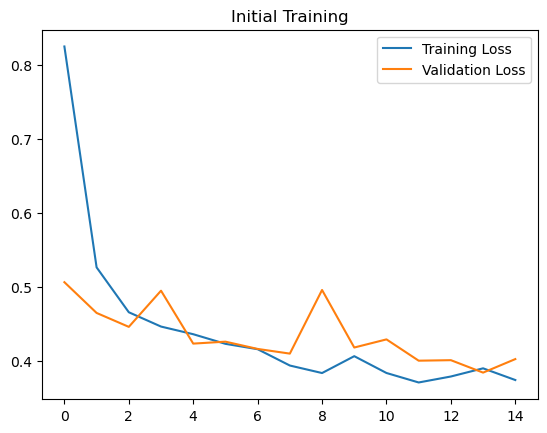

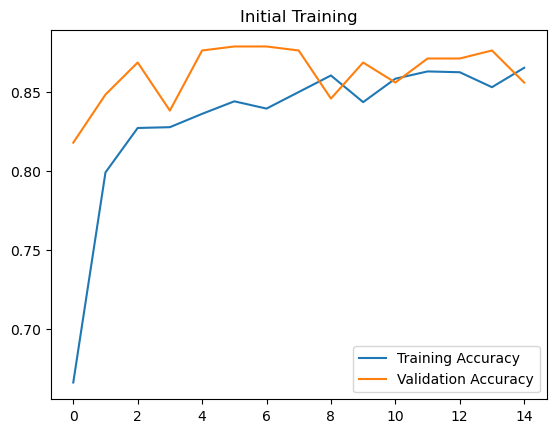

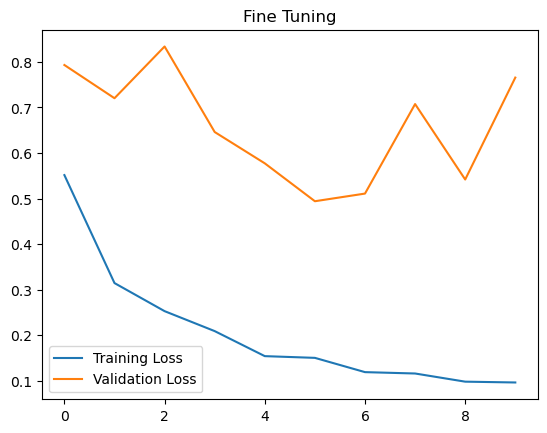

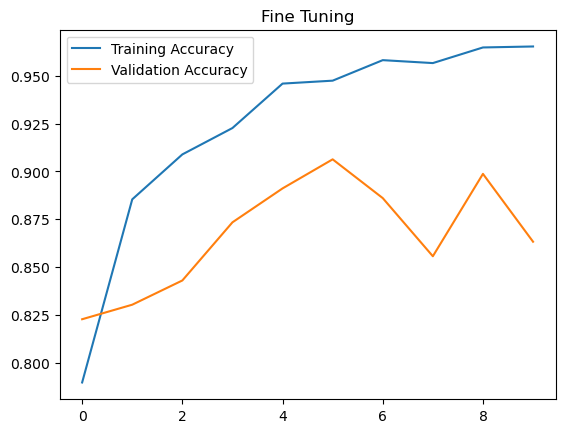

In [9]:
print(history.history.keys())
print(history_fine.history.keys())

# Plot loss and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Initial Training')
plt.legend()
plt.show()

# Repeat for accuracy if recorded
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Initial Training')
plt.legend()
plt.show()

# Plot loss and validation loss
plt.plot(history_fine.history['loss'], label='Training Loss')
plt.plot(history_fine.history['val_loss'], label='Validation Loss')
plt.title('Fine Tuning')
plt.legend()
plt.show()

# Repeat for accuracy if recorded
plt.plot(history_fine.history['accuracy'], label='Training Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.title('Fine Tuning')
plt.legend()
plt.show()


In [30]:
# Construct the path to the test directory
test_dir = os.path.join(dataset_dir, 'test')

# Data augmentation for test set
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Prepare test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Found 379 images belonging to 4 classes.


c:\Users\mika\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 350ms/step - accuracy: 0.8805 - loss: 0.4279
Test Loss: 0.43996182084083557
Test Accuracy: 0.8627968430519104


### Step 4: Real-Time Webcam Prediction

This needs to be run outside Jupyter notebook environment for real time webcam access and output. Test script is in webcam-predirector.py file.
Run in python shell: 

``
python webcam-predictor.py
``